## Initial Setup

In [ ]:
import os
import math
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
#from attention import Attention
from keras.layers import Dense, Dropout
from keras.layers import LSTM,TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Generating Synthetic Data
This part can be skipped if data is loaded directly from npy





In [ ]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

# Parameters
Lx = 10.0      # Length of the domain in the x direction
Ly = 10.0      # Length of the domain in the y direction
Nx = 28        # Number of spatial points in the x direction
Ny = 28        # Number of spatial points in the y direction
Nt = 4000      # Number of time steps
D_a = 0.01     # Diffusion coefficient for variable a
D_b = 0.01     # Diffusion coefficient for variable b
D_c = 0.01     # Diffusion coefficient for variable c (combination of a and b)
alpha = 0.1    # Influence of variable_a on variable_b
beta = 0.2     # Coefficient for variable_a in variable_c
gamma = 0.3    # Coefficient for variable_b in variable_c
neighborhood_size = 3  # Size of the neighborhood for convolution
lag_a = 1      # Lag for variable_a
lag_b = 1      # Lag for variable_b
update_factor_b = 0.6  # Update factor for variable_b

# Spatial and temporal discretization
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)
dx = x[1] - x[0]
dy = y[1] - y[0]

# Time discretization
dt = 0.01      # Time step
t = np.linspace(0, Nt * dt, Nt)

# Initialize variables
variable_a = np.zeros((Nt, Nx, Ny))
variable_b = np.zeros((Nt, Nx, Ny))
variable_b_cf = np.zeros((Nt, Nx, Ny))
variable_c = np.zeros((Nt, Nx, Ny))
variable_c_cf = np.zeros((Nt, Nx, Ny))

# Initial conditions
variable_a[0, :, :] = np.exp(-((X - Lx/2)**2 + (Y - Ly/2)**2) / 4)
variable_b[0, :, :] = np.sin(np.pi * X / Lx) + alpha * variable_a[0, :, :]
#variable_b_cf[0, :, :] = np.cos(np.pi * X / Lx) + alpha * variable_a[0, :, :]
variable_c[0, :, :] = beta * variable_a[0, :, :] + gamma * variable_b[0, :, :]
variable_c_cf[0, :, :] = beta * variable_a[0, :, :] + gamma * variable_b[0, :, :]

# Time-stepping loop
for n in range(1, Nt):
    # Diffusion Equation for variable_a with time lag
    laplacian_a = (np.roll(variable_a[n-1, :, :], 1, axis=1) - 2 * variable_a[n-1, :, :] + np.roll(variable_a[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_a[n-1, :, :], 1, axis=0) - 2 * variable_a[n-1, :, :] + np.roll(variable_a[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_a = D_a * laplacian_a
    variable_a[n, :, :] = variable_a[n-1, :, :] + dt * diffusion_term_a

    # Diffusion Equation for variable_b with time lag and dependence on lagged variable_a
    laplacian_b = (np.roll(variable_b[n-1, :, :], 1, axis=1) - 2 * variable_b[n-1, :, :] + np.roll(variable_b[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_b[n-1, :, :], 1, axis=0) - 2 * variable_b[n-1, :, :] + np.roll(variable_b[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_b = D_b * laplacian_b
    variable_b[n, :, :] = (variable_b[n-1, :, :] + dt * (diffusion_term_b + alpha * np.roll(diffusion_term_a, lag_a, axis=(0, 1))))
    variable_b_cf[n, :, :] = (variable_b[n-1, :, :] + dt * (diffusion_term_b + alpha * np.roll(diffusion_term_a, lag_a, axis=(0, 1))))

    variable_b_cf[n,10:15,10:15] = update_factor_b * variable_b_cf[n,10:15,10:15]

    # Convolution to compute the mean of per-pixel neighborhood of variable_b (excluding the pixel itself)
    kernel_size = 3
    neighborhood_sum = scipy.ndimage.convolve(variable_b[n, :, :], np.ones((kernel_size, kernel_size)), mode='constant', cval=0)
    neighborhood_mean = (neighborhood_sum - variable_b[n, :, :]) / (kernel_size**2 - 1)

    # Diffusion Equation for variable_c with time lag and dependence on lagged variable_a and lagged variable_b
    laplacian_c = (np.roll(variable_c[n-1, :, :], 1, axis=1) - 2 * variable_c[n-1, :, :] + np.roll(variable_c[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_c[n-1, :, :], 1, axis=0) - 2 * variable_c[n-1, :, :] + np.roll(variable_c[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_c = D_c * laplacian_c
    variable_c[n, :, :] = variable_c[n-1, :, :] + dt * diffusion_term_c + beta * dt * np.roll(diffusion_term_a, lag_a, axis=(0, 1)) + gamma * dt * (np.roll(variable_b[n, :, :], lag_b, axis=(0, 1)) + neighborhood_mean)

for n in range(1, Nt):
  # Diffusion Equation for variable_c with time lag and dependence on lagged variable_a and lagged variable_b
    laplacian_cf = (np.roll(variable_c_cf[n-1, :, :], 1, axis=1) - 2 * variable_c_cf[n-1, :, :] + np.roll(variable_c_cf[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_c_cf[n-1, :, :], 1, axis=0) - 2 * variable_c_cf[n-1, :, :] + np.roll(variable_c_cf[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_cf = D_c * laplacian_cf
    variable_c_cf[n, :, :] = variable_c_cf[n-1, :, :] + dt * diffusion_term_cf + beta * dt * np.roll(diffusion_term_a, lag_a, axis=(0, 1)) + gamma * dt * (np.roll(variable_b_cf[n, :, :], lag_b, axis=(0, 1)) + neighborhood_mean)


In [ ]:
a = variable_a.reshape(4000, 28, 28, 1)
b = variable_b.reshape(4000, 28, 28, 1)
c = variable_c.reshape(4000, 28, 28, 1)
c_cf = variable_c_cf.reshape(4000, 28, 28, 1)
c_tr = variable_c.reshape(4000, 28, 28, 1) #Creating target variable

In [ ]:
#Add lag before reshaping data
a = a[:-1]
b = b[:-1]
c = c[:-1]
c_cf = c_cf[1:]
c_tr = c_tr[1:]

In [ ]:
ate = np.mean(c_cf-c)
ate

-0.08971487035921025

In [ ]:
from copy import copy, deepcopy

b_tr = deepcopy(b)
b_tr[:,10:15,10:15,0] = b_tr[:,10:15,10:15,0]*0.6

In [ ]:
data_ws = np.concatenate([a, b, c, b_tr, c_cf, c_tr], 3)
print(data_ws.shape)

(3999, 28, 28, 6)


In [ ]:
np.save('/content/c_cf_true_with_spillover.npy',data_ws[:,:,:,[2,4]])

Padding zeros to data to make 30x30 grid that is divisible into 5x5 sub-grids

In [ ]:
data_ws_30 = np.zeros((3999,30,30,6))
data_ws_30[:,:28,:28,:] = data_ws


In [ ]:
data_ws_5x5 = np.zeros((3999*36,5,5,6))

In [ ]:
count = 0
for i in range (data_ws_30.shape[0]):
  for j in range(6):
    for k in range(6):
      x=j*5
      y=k*5
      #print(count, i, x, y)
      data_ws_5x5[count,:,:,:]=data_ws_30[i,x:x+5,y:y+5,:]
      count=count+1


In [ ]:
data_ws_5x5_flat = data_ws_5x5.reshape(data_ws_5x5.shape[0], -1, data_ws_5x5.shape[3])
data_ws_5x5_flat.shape

(143964, 25, 6)

## Propensity Score Model

In [ ]:
#Specifying covariates and treatment
cov = data_ws_5x5_flat[:,:,:1]
tr = data_ws_5x5_flat[:,:,1] # data[:,2] * 1.1

train_x = cov[:,:]
train_y = tr[:]
test_x = cov[:,:]
test_y = tr[:]

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(143964, 25, 1)
(143964, 25, 1)
(143964, 25)
(143964, 25)


In [ ]:
#for new dataset

train_x_r = train_x.reshape((-1,1))
test_x_r = test_x.reshape((-1,1))

train_y_r=train_y.reshape((-1))
test_y_r=test_y.reshape((-1))

scaler_f = StandardScaler()
train_x_r = scaler_f.fit_transform(train_x_r) #reshaping to 2d for standard scaling
test_x_r = scaler_f.transform(test_x_r) #reshaping to 2d for standard scaling

scaler_t = StandardScaler()
train_y_r = scaler_t.fit_transform(train_y_r.reshape(-1,1)) #reshaping to 2d for standard scaling
test_y_r = scaler_t.transform(test_y_r.reshape(-1,1)) #reshaping to 2d for standard scaling

train_x = train_x_r.reshape(train_x.shape)
test_x = test_x_r.reshape(test_x.shape)

train_y = train_y_r.reshape(train_y.shape)
test_y = test_y_r.reshape(test_y.shape)

In [ ]:
# convert an array of values into a dataset matrix
def reshape_features(dataset, timesteps=1):
    print(dataset.shape)
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    return X

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras.losses import Loss
#from attention import Attention

def mymodel(timestep, features, reg_l2):

    input = Input(shape=(timestep,features))
    x = LSTM(64, return_sequences=True)(input)
    x = Dropout(0.2)(x)
    x = LSTM(32, return_sequences=False)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input, outputs=output)

    return model

In [ ]:
features = 1
timestep = 25

model=mymodel(25,1, .01)
print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 25, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 25, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

checkpoint_path='./testmodel.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=60, mode='min', min_delta=0.001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

history=model.fit(train_x, train_y, epochs=10, batch_size=32, verbose=2, validation_split =0.2, shuffle=True,callbacks=keras_callbacks)

Epoch 1/10
3600/3600 - 41s - loss: 0.7219 - val_loss: 0.6829 - 41s/epoch - 11ms/step
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3600/3600 - 33s - loss: 0.7354 - val_loss: 0.6414 - 33s/epoch - 9ms/step
Epoch 3/10
3600/3600 - 25s - loss: 0.7153 - val_loss: 0.6413 - 25s/epoch - 7ms/step
Epoch 4/10
3600/3600 - 25s - loss: 0.6700 - val_loss: 0.5765 - 25s/epoch - 7ms/step
Epoch 5/10
3600/3600 - 25s - loss: 0.6360 - val_loss: 0.6119 - 25s/epoch - 7ms/step
Epoch 6/10
3600/3600 - 25s - loss: 0.6353 - val_loss: 0.5680 - 25s/epoch - 7ms/step
Epoch 7/10
3600/3600 - 25s - loss: 0.6342 - val_loss: 0.5676 - 25s/epoch - 7ms/step
Epoch 8/10
3600/3600 - 25s - loss: 0.6341 - val_loss: 0.5681 - 25s/epoch - 7ms/step
Epoch 9/10
3600/3600 - 25s - loss: 0.6343 - val_loss: 0.5675 - 25s/epoch - 7ms/step
Epoch 10/10
3600/3600 - 24s - loss: 0.6339 - val_loss: 0.5676 - 24s/epoch - 7ms/step


In [ ]:
prop_score = model.predict_on_batch(train_x)
iptw = 1 / prop_score
print(prop_score.shape)
print(iptw.shape)

(143964, 1)
(143964, 1)


In [ ]:
print(prop_score[:10,0])
print(iptw[:10,0])

[1.8601322e-07 4.8575994e-01 9.9900156e-01 9.9202174e-01 4.3862215e-06
 1.4300043e-07 2.8331446e-05 5.1008308e-01 9.9999857e-01 9.9999416e-01]
[5.3759620e+06 2.0586300e+00 1.0009995e+00 1.0080425e+00 2.2798667e+05
 6.9929855e+06 3.5296469e+04 1.9604650e+00 1.0000014e+00 1.0000058e+00]


In [ ]:
trainPred = model.predict(train_x)
testPred = model.predict(test_x)
print(testPred.shape)
print(trainPred.shape)

4499/4499 [==============================] - 14s 3ms/step
(143964, 1)
(143964, 1)


In [ ]:
#Reverting data back to 2D from 3D
train_x = train_x.reshape(-1, train_x.shape[2])
test_x = test_x.reshape(-1, test_x.shape[2])

print(train_x.shape)
print(trainPred.shape)
print(test_x.shape)
print(testPred.shape)

(3599100, 1)
(143964, 1)
(3599100, 1)
(143964, 1)


In [ ]:
# for new dataset

target = data_ws_5x5_flat[:,:,-1]
cf = data_ws_5x5_flat[:,:, [2,4]] #factual and counterfactual data
data = data_ws_5x5_flat[:,:,:3]
print(data.shape)
print(cf.shape)
print(target.shape)

(143964, 25, 3)
(143964, 25, 2)
(143964, 25)


## Train Validation Split

LSTM network expects the input data to be provided with a specific array structure in the form of: [samples, time steps, features]. We load the csv file and only retain the feature and target columns. The features and target are stored in separate np arrays.

In [ ]:
#for new dataset - Train on full dataset

LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = int(LEN_DATA * 1)

print('LEN_DATA:',LEN_DATA)
print('NUM_TRAIN:',NUM_TRAIN)

x_train = deepcopy(data[:,:,:])
x_test = deepcopy(data[:,:,:])

#split features and labels
y_train= deepcopy(target[:,:]) #target is last column i-e sea-ice
y_test= deepcopy(target[:,:]) #target is last column i-e sea-ice


LEN_DATA: 143964
NUM_TRAIN: 143964


## Creating Treated and Untreated versions of Test Data

In [ ]:
#for new dataset

x_treated = x_test.copy()
x_untreated = x_test.copy()
x_treated[:,:,1] = data_ws_5x5_flat[:,:,3]

In [ ]:
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)
print('x_test.shape:',x_test.shape)
print('y_test.shape:',y_test.shape)
print('x_treated.shape:',x_treated.shape)
print('x_untreated.shape:',x_untreated.shape)

x_train.shape: (143964, 25, 3)
y_train.shape: (143964, 25)
x_test.shape: (143964, 25, 3)
y_test.shape: (143964, 25)
x_treated.shape: (143964, 25, 3)
x_untreated.shape: (143964, 25, 3)


## Reshaping Input and Target Features

In [ ]:
# convert an array of values into a dataset matrix
def reshape_features(dataset, timesteps=1):
    print(dataset.shape)
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    return X

## Normalization


In [ ]:
#for new dataset

x_train_r = x_train.reshape((-1,3))
x_test_r = x_test.reshape((-1,3))
x_treated_r = x_treated.reshape((-1,3))
x_untreated_r = x_untreated.reshape((-1,3))

y_train_r = y_train.reshape((-1))
y_test_r = y_test.reshape((-1))

scaler_f = StandardScaler()
x_train_r = scaler_f.fit_transform(x_train_r) #reshaping to 2d for standard scaling
x_test_r = scaler_f.transform(x_test_r) #reshaping to 2d for standard scaling
x_treated_r = scaler_f.fit_transform(x_treated_r) #reshaping to 2d for standard scaling
x_untreated_r = scaler_f.transform(x_untreated_r) #reshaping to 2d for standard scaling

scaler_l = StandardScaler()
y_train_r = scaler_l.fit_transform(y_train_r.reshape(-1,1)) #reshaping to 2d for standard scaling
y_test_r = scaler_l.transform(y_test_r.reshape(-1,1)) #reshaping to 2d for standard scaling

x_train = x_train_r.reshape(x_train.shape)
x_test = x_test_r.reshape(x_test.shape)
x_treated = x_treated_r.reshape(x_treated.shape)
x_untreated = x_untreated_r.reshape(x_untreated.shape)

y_train = y_train_r.reshape(y_train.shape)
y_test = y_test_r.reshape(y_test.shape)

In [ ]:
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)
print('x_test.shape:',x_test.shape)
print('y_test.shape:',y_test.shape)

print('x_treated.shape:',x_treated.shape)
print('x_untreated.shape:',x_untreated.shape)

x_train.shape: (143964, 25, 3)
y_train.shape: (143964, 25)
x_test.shape: (143964, 25, 3)
y_test.shape: (143964, 25)
x_treated.shape: (143964, 25, 3)
x_untreated.shape: (143964, 25, 3)


## Building Model

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.losses import Loss
#from attention import Attention

def myModelMain(timestep, features, reg_l2):

    x = Input(shape=(timestep,features), name='input')

    # representation
    phi = LSTM(64, return_sequences=True,name='phi_1')(x)
    phi = Dropout(0.2)(phi)
    phi = LSTM(32, return_sequences=True,name='phi_2')(phi)
    phi = LSTM(32, return_sequences=False,name='phi_3')(phi)
    phi = Dense(units=25, activation='elu', kernel_initializer='RandomNormal',name='phi_4')(phi)
    phi = Dropout(0.2)(phi)

    y0_hidden = Dense(units=25, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_1')(phi)
    y0_hidden = Dense(units=25, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_2')(y0_hidden)
    y0_predictions = Dense(units=25, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y0_predictions')(y0_hidden)
    model = Model(inputs=x, outputs=y0_predictions)

    return model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 25, 3)]           0         
                                                                 
 phi_1 (LSTM)                (None, 25, 64)            17408     
                                                                 
 dropout_1 (Dropout)         (None, 25, 64)            0         
                                                                 
 phi_2 (LSTM)                (None, 25, 32)            12416     
                                                                 
 phi_3 (LSTM)                (None, 32)                8320      
                                                                 
 phi_4 (Dense)               (None, 25)                825       
                                                                 
 dropout_2 (Dropout)         (None, 25)                0   

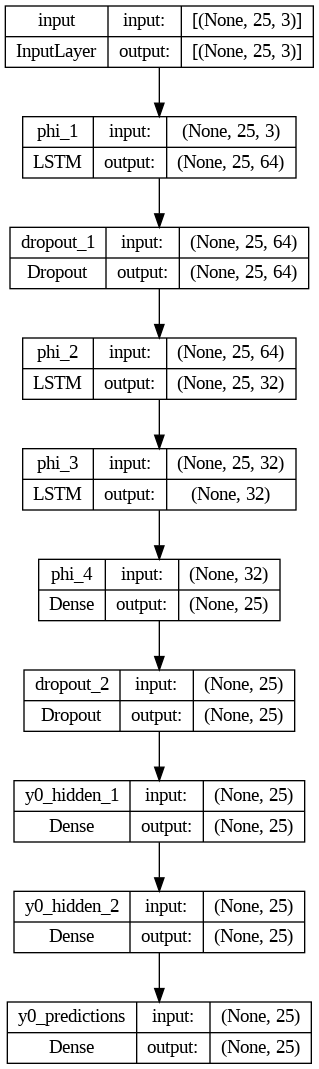

In [ ]:
model1=myModelMain(25,3, .01)

print(model1.summary())
tf.keras.utils.plot_model(model1, show_shapes=True, show_layer_names=True, to_file='slearner.png')

## Compiling the Network and Fitting Model

In [ ]:
# We will use the MSE loss function as base loss
loss_fn = tf.keras.losses.MeanSquaredError() #specify the loss

In [ ]:
from tensorflow.keras.optimizers import SGD

val_split=0.2
batch_size=64
verbose=1
i = 0
tf.random.set_seed(i)
np.random.seed(i)

#optimzer hyperparameters
sgd_lr = 1e-5
momentum = 0.9

#Compiling the network
model1.compile(loss=loss_fn, optimizer='adam',sample_weight_mode = 'temporal')
checkpoint_path='./testmodel.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=60, mode='min', min_delta=0.001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

model1.fit(x=x_train,y=y_train,
                validation_split=0.2,
                epochs=50,
                batch_size=batch_size,
                shuffle=True,
                sample_weight=iptw,
                callbacks=keras_callbacks,
                verbose=verbose)


Epoch 1/50
1797/1800 [============================>.] - ETA: 0s - loss: 210127.1250

1800/1800 [==============================] - 32s 13ms/step - loss: 209904.0781 - val_loss: 675126.1250
Epoch 2/50
  13/1800 [..............................] - ETA: 15s - loss: 79146.5703

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1797/1800 [============================>.] - ETA: 0s - loss: 65773.8828

1800/1800 [==============================] - 21s 12ms/step - loss: 65728.8047 - val_loss: 625477.8125
Epoch 3/50
1797/1800 [============================>.] - ETA: 0s - loss: 45015.0430

1800/1800 [==============================] - 21s 12ms/step - loss: 44985.0859 - val_loss: 791071.8750
Epoch 4/50
1795/1800 [============================>.] - ETA: 0s - loss: 35863.4648

1800/1800 [==============================] - 21s 11ms/step - loss: 35836.6367 - val_loss: 908730.9375
Epoch 5/50
1800/1800 [==============================] - ETA: 0s - loss: 30401.1914

1800/1800 [==============================] - 21s 12ms/step - loss: 30401.1914 - val_loss: 829317.6875
Epoch 6/50
1798/1800 [============================>.] - ETA: 0s - loss: 25657.6348

1800/1800 [==============================] - 21s 12ms/step - loss: 25656.4004 - val_loss: 757869.2500
Epoch 7/50
1797/1800 [============================>.] - ETA: 0s - loss: 22968.1484

1800/1800 [==============================] - 21s 11ms/step - loss: 22962.2441 - val_loss: 708935.3125
Epoch 8/50
1797/1800 [============================>.] - ETA: 0s - loss: 22101.8184

1800/1800 [==============================] - 21s 12ms/step - loss: 22114.0117 - val_loss: 792294.1875
Epoch 9/50
1798/1800 [============================>.] - ETA: 0s - loss: 18511.6660

1800/1800 [==============================] - 20s 11ms/step - loss: 18523.1348 - val_loss: 833261.5625
Epoch 10/50
1796/1800 [============================>.] - ETA: 0s - loss: 17385.1504

1800/1800 [==============================] - 19s 10ms/step - loss: 17387.5645 - val_loss: 671543.0625
Epoch 11/50
1798/1800 [============================>.] - ETA: 0s - loss: 16561.0430

1800/1800 [==============================] - 19s 11ms/step - loss: 16557.7891 - val_loss: 790901.5000
Epoch 12/50
1800/1800 [==============================] - ETA: 0s - loss: 14954.3564

1800/1800 [==============================] - 19s 10ms/step - loss: 14954.3564 - val_loss: 771674.6250
Epoch 13/50
1796/1800 [============================>.] - ETA: 0s - loss: 13397.3711

1800/1800 [==============================] - 19s 11ms/step - loss: 13393.4512 - val_loss: 783678.8750
Epoch 14/50
1799/1800 [============================>.] - ETA: 0s - loss: 12979.4453

1800/1800 [==============================] - 19s 11ms/step - loss: 12976.5420 - val_loss: 819305.2500
Epoch 15/50
1798/1800 [============================>.] - ETA: 0s - loss: 11667.4824

1800/1800 [==============================] - 19s 10ms/step - loss: 11664.2783 - val_loss: 823781.0000
Epoch 16/50
1799/1800 [============================>.] - ETA: 0s - loss: 11838.5703

1800/1800 [==============================] - 19s 11ms/step - loss: 11835.9678 - val_loss: 852887.8125
Epoch 17/50
1795/1800 [============================>.] - ETA: 0s - loss: 10317.4697

1800/1800 [==============================] - 19s 10ms/step - loss: 10313.1260 - val_loss: 1012501.8750
Epoch 18/50
1795/1800 [============================>.] - ETA: 0s - loss: 10188.5430

1800/1800 [==============================] - 19s 11ms/step - loss: 10181.7344 - val_loss: 988948.6250
Epoch 19/50
1800/1800 [==============================] - ETA: 0s - loss: 9347.9570

1800/1800 [==============================] - 19s 10ms/step - loss: 9347.9570 - val_loss: 1146948.8750
Epoch 20/50
1798/1800 [============================>.] - ETA: 0s - loss: 9881.9219

1800/1800 [==============================] - 19s 11ms/step - loss: 9879.5938 - val_loss: 928454.5000
Epoch 21/50
1796/1800 [============================>.] - ETA: 0s - loss: 8299.7852

1800/1800 [==============================] - 19s 10ms/step - loss: 8299.0869 - val_loss: 845127.7500
Epoch 22/50
1795/1800 [============================>.] - ETA: 0s - loss: 8187.2773

1800/1800 [==============================] - 19s 11ms/step - loss: 8186.6938 - val_loss: 1065703.3750
Epoch 23/50
1797/1800 [============================>.] - ETA: 0s - loss: 8381.5791

1800/1800 [==============================] - 19s 11ms/step - loss: 8381.2246 - val_loss: 982585.0000
Epoch 24/50
1795/1800 [============================>.] - ETA: 0s - loss: 7778.9419

1800/1800 [==============================] - 19s 10ms/step - loss: 7772.9321 - val_loss: 1163150.0000
Epoch 25/50
1798/1800 [============================>.] - ETA: 0s - loss: 8489.6162

1800/1800 [==============================] - 19s 11ms/step - loss: 8486.6113 - val_loss: 830795.6875
Epoch 26/50
1800/1800 [==============================] - ETA: 0s - loss: 7294.1675

1800/1800 [==============================] - 19s 10ms/step - loss: 7294.1675 - val_loss: 853629.1875
Epoch 27/50
1799/1800 [============================>.] - ETA: 0s - loss: 6766.6602

1800/1800 [==============================] - 20s 11ms/step - loss: 6768.1133 - val_loss: 982103.8125
Epoch 28/50
1799/1800 [============================>.] - ETA: 0s - loss: 7560.8271

1800/1800 [==============================] - 19s 11ms/step - loss: 7561.0278 - val_loss: 1012451.7500
Epoch 29/50
1798/1800 [============================>.] - ETA: 0s - loss: 6525.3423

1800/1800 [==============================] - 20s 11ms/step - loss: 6523.4043 - val_loss: 2188443.5000
Epoch 30/50
1799/1800 [============================>.] - ETA: 0s - loss: 6990.8003

1800/1800 [==============================] - 19s 11ms/step - loss: 6989.9248 - val_loss: 606757.3125
Epoch 31/50
1795/1800 [============================>.] - ETA: 0s - loss: 5680.4141

1800/1800 [==============================] - 19s 10ms/step - loss: 5677.5996 - val_loss: 1112676.5000
Epoch 32/50
1800/1800 [==============================] - ETA: 0s - loss: 6090.3320

1800/1800 [==============================] - 19s 11ms/step - loss: 6090.3320 - val_loss: 921520.0625
Epoch 33/50
1800/1800 [==============================] - ETA: 0s - loss: 6119.8398

1800/1800 [==============================] - 19s 10ms/step - loss: 6119.8398 - val_loss: 1145087.1250
Epoch 34/50
1800/1800 [==============================] - ETA: 0s - loss: 5691.7119

1800/1800 [==============================] - 20s 11ms/step - loss: 5691.7119 - val_loss: 969296.0625
Epoch 35/50
1797/1800 [============================>.] - ETA: 0s - loss: 7285.1484

1800/1800 [==============================] - 19s 11ms/step - loss: 7279.6577 - val_loss: 842942.3125
Epoch 36/50
1795/1800 [============================>.] - ETA: 0s - loss: 5795.5737

1800/1800 [==============================] - 19s 11ms/step - loss: 5791.0015 - val_loss: 756576.5000
Epoch 37/50
1796/1800 [============================>.] - ETA: 0s - loss: 5178.1836

1800/1800 [==============================] - 19s 11ms/step - loss: 5176.8081 - val_loss: 753726.0000
Epoch 38/50
1797/1800 [============================>.] - ETA: 0s - loss: 4953.6260

1800/1800 [==============================] - 20s 11ms/step - loss: 4950.7324 - val_loss: 975572.3750
Epoch 39/50
1798/1800 [============================>.] - ETA: 0s - loss: 5682.1997

1800/1800 [==============================] - 19s 11ms/step - loss: 5689.3711 - val_loss: 803880.5000
Epoch 40/50
1800/1800 [==============================] - ETA: 0s - loss: 4868.6606

1800/1800 [==============================] - 19s 11ms/step - loss: 4868.6606 - val_loss: 1136026.1250
Epoch 41/50
1797/1800 [============================>.] - ETA: 0s - loss: 4628.7036

1800/1800 [==============================] - 19s 11ms/step - loss: 4632.4351 - val_loss: 1199487.0000
Epoch 42/50
1799/1800 [============================>.] - ETA: 0s - loss: 4807.9966

1800/1800 [==============================] - 19s 11ms/step - loss: 4807.0298 - val_loss: 1210909.8750
Epoch 43/50
1800/1800 [==============================] - ETA: 0s - loss: 4692.9336

1800/1800 [==============================] - 19s 10ms/step - loss: 4692.9336 - val_loss: 1234275.5000
Epoch 44/50
1799/1800 [============================>.] - ETA: 0s - loss: 4575.6421

1800/1800 [==============================] - 20s 11ms/step - loss: 4575.0859 - val_loss: 1716896.0000
Epoch 45/50
1799/1800 [============================>.] - ETA: 0s - loss: 4232.8145

1800/1800 [==============================] - 19s 10ms/step - loss: 4235.5098 - val_loss: 1179070.7500
Epoch 46/50
1797/1800 [============================>.] - ETA: 0s - loss: 4651.5508

1800/1800 [==============================] - 19s 11ms/step - loss: 4650.9302 - val_loss: 864416.8750
Epoch 47/50
1798/1800 [============================>.] - ETA: 0s - loss: 4116.1309

1800/1800 [==============================] - 19s 11ms/step - loss: 4114.5483 - val_loss: 1613452.0000
Epoch 48/50
1800/1800 [==============================] - ETA: 0s - loss: 4052.3906

1800/1800 [==============================] - 19s 11ms/step - loss: 4052.3906 - val_loss: 1801289.0000
Epoch 49/50
1797/1800 [============================>.] - ETA: 0s - loss: 4273.3486

1800/1800 [==============================] - 19s 11ms/step - loss: 4274.6157 - val_loss: 1797238.6250
Epoch 50/50
1795/1800 [============================>.] - ETA: 0s - loss: 3875.8977

1800/1800 [==============================] - 20s 11ms/step - loss: 3878.2046 - val_loss: 2091080.2500


## Causal Effect Estimation (With Spatial Interference)
The same code can be used for data without spatial interference

In [ ]:
import pandas as pd
import numpy as np


y0_pred=model1.predict(x_untreated)
y1_pred=model1.predict(x_treated)

4499/4499 [==============================] - 17s 4ms/step


In [ ]:
y_pred = model1.predict(x_test) #(With Spillover)

4499/4499 [==============================] - 17s 4ms/step


In [ ]:
np.save('/content/y0_pred_with_spillover.npy',y0_pred)
np.save('/content/y1_pred_with_spillover.npy',y1_pred)

In [ ]:
y0_pred = np.load('/content/y0_pred_with_spillover.npy')
y1_pred = np.load('/content/y1_pred_with_spillover.npy')

In [ ]:
#RMSE Model
from sklearn.metrics import mean_squared_error
from math import sqrt

y_pred_r = scaler_l.inverse_transform(y_pred)
y_test_r = scaler_l.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(y_test_r, y_pred_r))
print('Test RMSE: %.3f' % rmse)

In [ ]:
#RMSE Treated
from sklearn.metrics import mean_squared_error
from math import sqrt

y1_pred_r = scaler_l.inverse_transform(y1_pred)

rmse = sqrt(mean_squared_error(cf[:,:,1], y1_pred_r))
print('Treated RMSE: %.3f' % rmse)

In [ ]:
np.save('/content/y0_pred_recon_with_spillover.npy',y0_pred_r)
np.save('/content/y1_pred_recon_with_spillover.npy',y1_pred_r)

In [ ]:
cate_true=(cf[:,:,1]-cf[:,:,0]).squeeze() #(With Spillover)
cate_true.shape

In [ ]:
ate_true=tf.reduce_mean(cate_true)
ate_true

In [ ]:
#for new dataset (With Spillover)
cate_pred=(y1_pred_r-y0_pred_r).squeeze()
cate_true=(cf[:,:,1]-cf[:,:,0]).squeeze()

ate_pred=tf.reduce_mean(cate_pred)
ate_true=tf.reduce_mean(cate_true)

print("True ATE:",ate_true.numpy())
print("Estimated ATE:",ate_pred.numpy())

In [ ]:
#for new dataset (With Spillover)
#PEHE
pehe=tf.reduce_mean( tf.square( ( cate_true - cate_pred) ) )
sqrt_pehe=tf.sqrt(pehe).numpy()
print("\nSQRT PEHE:",sqrt_pehe)